# Optimization with PyMoosh

Many physical and engineering problems require an optimization phase, in order to find an object or a structure that best fits a given constraint or objective.

To this end, the first step is to define the objective the structure must meet or approach. This can be as simple as  maximising or minimising a specific parameter (e.g. reflectivity or transmissivity at a given wavelength), or as complex as angularly separating polarizations or maximizing the amount of energy absorbed in a specific layer of the material.

In any case, this definition needs to be written as an **objective function**, that counts the proximity to the objective.

In the first example below, we simply want to design a dielectric mirror, so we want to maximise the reflectance for a given wavelength.
For this, we will be using the *coefficient(...)* function that returns the reflectivity and transmitivity of a structure.

In [1]:
import PyMoosh as PM
import numpy as np

# The wavelength we are interested in
wav = 600
# The angle of incidence and polarization the structure is intended for
angle = 25 * np.pi / 180
polar = 0 # 0 for TE, 1 for TM

def objective_function(layers, wavelength=wav, angle=angle, polar=polar):
    """
    We want to maximise the reflectance of the structure for the chosen wavelength
    """
    nb_lay = len(layers)//2
    mat = [1, 1.5, 2]
    stack = [0] + [1, 2] * nb_lay + [0]
    thickness = [0] + [t for t in layers] + [0]
    structure = PM.Structure(mat, stack, thickness, verbose=False)
    r, t, R, T = PM.coefficient(structure, wavelength, angle, polar)
    return 1-R

['/home/denis/Documents/git/PyMoosh/notebooks/Basic_tutorials', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/denis/.local/lib/python3.10/site-packages', '/home/denis/Documents/git/PyMoosh', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages/IPython/extensions', '/home/denis/.ipython']


/home/denis/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Optimization algorithms 

There are many different optimization algorithms out there. Luckily for you, we selected one that works particularly well for photonics: [Differential Evolution](https://en.wikipedia.org/wiki/Differential_evolution)

In its simplest form, it takes 4 arguments:
- The **objective function** you wrote
- The **budget**, or how many iterations it can make before stopping
- The **minimum value** of every parameter, defining the lower bound of parameter space
- The **maximum value** of every parameter, defining the upper bound of parameter space

It will output 2 values:
- The **best structure** in terms of objective function
- The **convergence** showing you how the cost of the best structures evolved throughout the algorithm

See how it goes:

In [2]:
budget = 1000 #

nb_layers = 10 # We want a 10-layer Dielectric mirror
min_lay = 10 # No layer thinner than 10 nm
max_lay = 300 # No layer thicker than 800 nm (half the largestthe wavelength)

X_min = np.array([min_lay] * nb_layers)
X_max = np.array([max_lay] * nb_layers)

best, convergence = PM.differential_evolution(objective_function, budget, X_min, X_max)

## Visualising the result

Now the optimization algorithm has stopped, let's visualise what happened. To this end, we will show both the evolution of the cost function as the number of iterations increases, and the spectrum of the final structure.

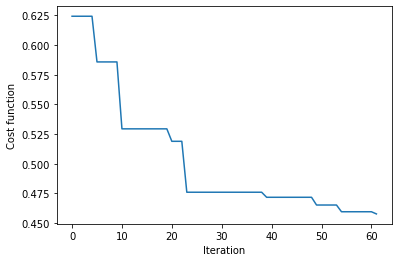

Text(0, 0.5, 'Reflectivity')

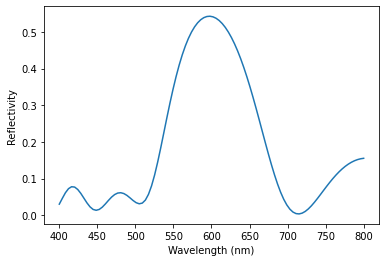

In [3]:
import matplotlib.pyplot as plt

plt.plot(convergence)
plt.xlabel("Iteration")
plt.ylabel("Cost function")
plt.show()


wav_beg = 400
wav_end = 800
nb_wav = 100
reflectivity = np.zeros(nb_wav)
wav_list = np.linspace(wav_beg, wav_end, nb_wav)
mat = [1, 1.5, 2]
stack = [0] + [1, 2] * (nb_layers//2) + [0]
thickness = [0] + [t for t in best] + [0]
structure = PM.Structure(mat, stack, thickness, verbose=False)
for i, wav in enumerate(wav_list):
    r, t, R, T = PM.coefficient(structure, wav, angle, polar)
    reflectivity[i] = R

plt.plot(wav_list, reflectivity)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectivity")

This isn't very good, isn't it? (I cannot be sure because the algorithm is not fully deterministic, but there is a very low probability that you had a satisfying result).

This is because the budget was much too low for the objective it had. Let's crank it up! We should also increase the number of layers if we really want to reach a high reflectivty.

**This could be long, be warned.**

In [4]:
budget = 15000

nb_layers = 30 # We want a 30-layer Dielectric mirror
min_lay = 10 # No layer thinner than 10 nm
max_lay = 300 # No layer thicker than 800 nm (half the wavelength)

X_min = np.array([min_lay] * nb_layers)
X_max = np.array([max_lay] * nb_layers)

best, convergence = PM.differential_evolution(objective_function, budget, X_min, X_max)

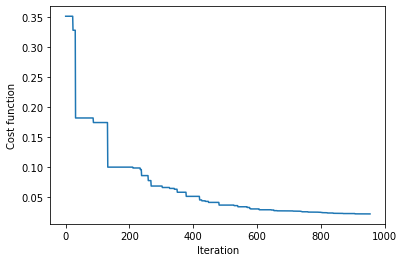

Text(0, 0.5, 'Reflectivity')

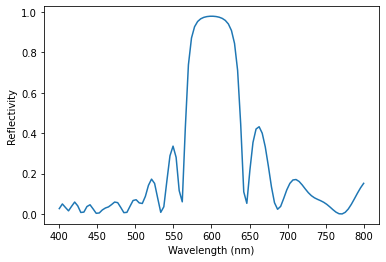

In [5]:

plt.plot(convergence)
plt.xlabel("Iteration")
plt.ylabel("Cost function")
plt.show()



reflectivity = np.zeros(nb_wav)
wav_list = np.linspace(wav_beg, wav_end, nb_wav)
mat = [1, 1.5, 2]
stack = [0] + [1, 2] * (nb_layers//2) + [0]
thickness = [0] + [t for t in best] + [0]
structure = PM.Structure(mat, stack, thickness, verbose=False)
for i, wav in enumerate(wav_list):
    r, t, R, T = PM.coefficient(structure, wav, angle, polar)
    reflectivity[i] = R

plt.plot(wav_list, reflectivity)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectivity")

## More advanced algorithms

PyMoosh includes other optimization algorithms than DE (more precisely, cur-to-best DE).

First, it includes the 2 variants of DE that have been found to be most reliable for photonics problems:
- `QODE` (Quasi Oppositional) : changes the initialisation to better spread on the whole domain. Takes the same arguments as `differential_evolution`.
- `QNDE` (Quasi Newton DE): the same thing, but ends with a gradient descent for a part of the budget. Takes an additional `bduget_bfgs` argument.

Talking about DE arguments, it is possible to give the mutation `f1`, `f2` and crossover `cr` hyperparameter values as keyword arguments to any of these functions